
image 1/1 /Users/shihab/UIB/Hackathon/BOX-DETECTION/WhatsApp Image 2025-02-14 at 12.10.43 (2).jpeg: 800x608 45 Cartons, 259.0ms
Speed: 4.5ms preprocess, 259.0ms inference, 3.0ms postprocess per image at shape (1, 3, 800, 608)
Total columns detected: 2
Column 1: 3 boxes
Column 2: 4 boxes


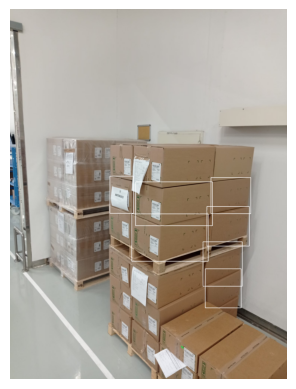

In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO  

# Load the trained YOLO model
model = YOLO("yolo_weights/best.pt")  

# Path to the image
image_path = "BOX-DETECTION/WhatsApp Image 2025-02-14 at 12.10.43 (2).jpeg"

# Confidence threshold
CONF_THRESH = 0.85  
X_THRESHOLD_SCALE = 0.5  # Adjust based on box width
Y_THRESHOLD = 100  # Allows small vertical gaps between stacked boxes

# Enable debugging (set to False to disable)
DEBUG = True  

# Run inference
results = model(image_path)

# Read the image
image = cv2.imread(image_path)

# List to store detected bounding boxes
boxes = []

for result in results:
    for box in result.boxes:
        if box.conf[0] >= CONF_THRESH:
            x1, y1, x2, y2 = map(int, box.xyxy[0])  # Bounding box coordinates
            boxes.append((x1, y1, x2, y2))

# Sort boxes by x1 (left edge) to group them into vertical stacks
boxes.sort(key=lambda b: b[0])

# Dynamic X_THRESHOLD based on average box width
if boxes:
    avg_box_width = np.mean([b[2] - b[0] for b in boxes])
    X_THRESHOLD = int(avg_box_width * X_THRESHOLD_SCALE)
else:
    X_THRESHOLD = 100

# Group boxes into columns
columns = []
for box in boxes:
    placed = False
    for column in columns:
        # Check if the new box is horizontally aligned with an existing column
        if abs(column[-1][0] - box[0]) < X_THRESHOLD:
            column.append(box)
            placed = True
            break
    if not placed:
        columns.append([box])

# Further refine columns by ensuring vertically aligned boxes belong to the same stack
for column in columns:
    column.sort(key=lambda b: b[1])  # Sort by y1 (top to bottom)

    refined_stacks = []
    current_stack = [column[0]]

    for i in range(1, len(column)):
        prev_box = current_stack[-1]
        curr_box = column[i]

        # If the gap between boxes is small, they belong to the same stack
        if curr_box[1] - prev_box[3] <= Y_THRESHOLD:
            current_stack.append(curr_box)
        else:
            refined_stacks.append(current_stack)
            current_stack = [curr_box]

    refined_stacks.append(current_stack)

    # Replace the original column with the refined stacks
    column[:] = refined_stacks

# ===== Debugging Section =====
if DEBUG:
    print(f"Total columns detected: {len(columns)}")
    for i, column in enumerate(columns):
        print(f"Column {i+1}: {sum(len(stack) for stack in column)} boxes")

    # Draw all bounding boxes in white for debugging
    for x1, y1, x2, y2 in boxes:
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 255, 255), 2)  # White box

# Draw bounding boxes for stacks with more than 5 boxes
for column in columns:
    for stack in column:
        if len(stack) > 5:  # Only mark stacks with more than 5 boxes
            # Get topmost and bottommost bounding boxes in the stack
            topmost = min(stack, key=lambda b: b[1])  # Smallest y1
            bottommost = max(stack, key=lambda b: b[3])  # Largest y2

            # Get bounding box for the entire stack
            x1 = min(b[0] for b in stack)
            x2 = max(b[2] for b in stack)
            y1 = topmost[1]
            y2 = bottommost[3]

            # Draw the bounding box for the entire stack
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 5)  # Red box for stacks >5

            # Annotate stack count at the top
            x_mid = (x1 + x2) // 2
            cv2.putText(image, f"{len(stack)}", (x_mid, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 2)

# Convert BGR to RGB for correct display
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


image 1/1 /Users/shihab/UIB/Hackathon/BOX-DETECTION/WhatsApp Image 2025-02-14 at 12.10.43 (1).jpeg: 800x608 25 Cartons, 228.1ms
Speed: 3.0ms preprocess, 228.1ms inference, 1.5ms postprocess per image at shape (1, 3, 800, 608)


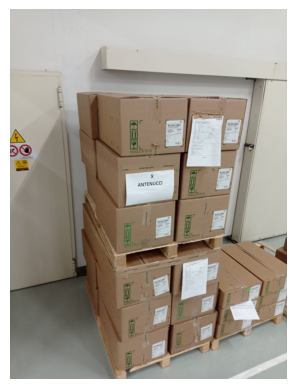

Stacked boxes per column: [2, 3]


In [105]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO  

# Load the trained YOLO model
model = YOLO("yolo_weights/best.pt")  

# Path to the image
image_path = "BOX-DETECTION/WhatsApp Image 2025-02-18 at 14.24.24.jpeg"
image_path = "BOX-DETECTION/WhatsApp Image 2025-02-14 at 12.10.43.jpeg"
# image_path = "BOX-DETECTION/WhatsApp Image 2025-02-14 at 12.12.26 (1).jpeg"

image_path = "BOX-DETECTION/WhatsApp Image 2025-02-14 at 12.10.43 (1).jpeg"

# Confidence threshold
CONF_THRESH = 0.85  

# Run inference
results = model(image_path)

# Read the image
image = cv2.imread(image_path)

# List to store detected bounding boxes
boxes = []

for result in results:
    for box in result.boxes:
        if box.conf[0] >= CONF_THRESH:
            x1, y1, x2, y2 = map(int, box.xyxy[0])  # Bounding box coordinates
            boxes.append((x1, y1, x2, y2))

# Sort boxes by x1 (left edge) to group them into vertical stacks
boxes.sort(key=lambda b: b[0])

# Define a threshold for grouping boxes in the same column
X_THRESHOLD = 100  # Adjust based on how close columns are

# Group boxes into columns
columns = []
for box in boxes:
    placed = False
    for column in columns:
        if abs(column[-1][0] - box[0]) < X_THRESHOLD:  # Compare left edges
            column.append(box)
            placed = True
            break
    if not placed:
        columns.append([box])

# Count the number of stacked boxes in each column
column_counts = [len(col) for col in columns]

# Draw bounding boxes and annotate column counts, only marking columns with more than 5 stacked boxes
for col_idx, column in enumerate(columns):
    if len(column) > 5:  # Only mark columns with more than 5 stacked boxes
        # Get topmost and bottommost bounding boxes in the column
        topmost = min(column, key=lambda b: b[1])  # Box with minimum y1 (topmost)
        bottommost = max(column, key=lambda b: b[3])  # Box with maximum y2 (bottommost)

        # Get the coordinates for the bounding box of the entire stack
        x1, y1, x2, y2 = topmost[0], topmost[1], bottommost[2], bottommost[3]

        # Draw the bounding box for the entire column
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 5)  # Red box for the entire stack

        # Annotate the column count at the top of the stack
        x_mid = (x1 + x2) // 2  # Middle x of the entire stack
        cv2.putText(image, f"{len(column)}", (x_mid, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 2)

# Convert BGR to RGB for correct display
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

# Print the number of stacked boxes in each column
print("Stacked boxes per column:", column_counts)



image 1/1 /Users/shihab/UIB/Hackathon/BOX-DETECTION/WhatsApp Image 2025-02-14 at 12.12.27.jpeg: 800x608 71 Cartons, 360.8ms
Speed: 5.5ms preprocess, 360.8ms inference, 0.9ms postprocess per image at shape (1, 3, 800, 608)


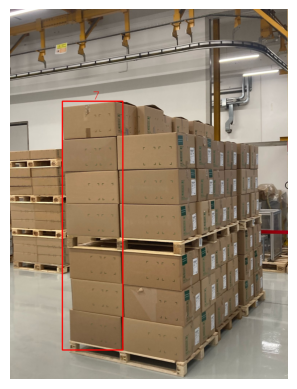

Stacked boxes per column: [7, 5]


In [122]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO  

# Load the trained YOLO model
model = YOLO("yolo_weights/best.pt")  

# Path to the image
image_path = "BOX-DETECTION/WhatsApp Image 2025-02-18 at 14.24.24.jpeg"
image_path = "BOX-DETECTION/WhatsApp Image 2025-02-14 at 12.12.27.jpeg"
# image_path = "BOX-DETECTION/WhatsApp Image 2025-02-14 at 12.12.26 (1).jpeg"

# Confidence threshold
CONF_THRESH = 0.85  

# Run inference
results = model(image_path)

# Read the image
image = cv2.imread(image_path)

# List to store detected bounding boxes
boxes = []

for result in results:
    for box in result.boxes:
        if box.conf[0] >= CONF_THRESH:
            x1, y1, x2, y2 = map(int, box.xyxy[0])  # Bounding box coordinates
            boxes.append((x1, y1, x2, y2))

# Sort boxes by x1 (left edge) to group them into vertical stacks
boxes.sort(key=lambda b: b[0])

# Define a threshold for grouping boxes in the same column
X_THRESHOLD = 100  # Adjust based on how close columns are

# Group boxes into columns
columns = []
for box in boxes:
    placed = False
    for column in columns:
        if abs(column[-1][0] - box[0]) < X_THRESHOLD:  # Compare left edges
            column.append(box)
            placed = True
            break
    if not placed:
        columns.append([box])

# Count the number of stacked boxes in each column
column_counts = [len(col) for col in columns]

# Draw bounding boxes and annotate column counts, only marking columns with more than 5 stacked boxes
for col_idx, column in enumerate(columns):
    if len(column) > 5:  # Only mark columns with more than 5 stacked boxes
        # Get topmost and bottommost bounding boxes in the column
        topmost = min(column, key=lambda b: b[1])  # Box with minimum y1 (topmost)
        bottommost = max(column, key=lambda b: b[3])  # Box with maximum y2 (bottommost)

        # Get the coordinates for the bounding box of the entire stack
        x1, y1, x2, y2 = topmost[0], topmost[1], bottommost[2], bottommost[3]

        # Draw the bounding box for the entire column
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 5)  # Red box for the entire stack

        # Annotate the column count at the top of the stack
        x_mid = (x1 + x2) // 2  # Middle x of the entire stack
        cv2.putText(image, f"{len(column)}", (x_mid, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 2)

# Convert BGR to RGB for correct display
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

# Print the number of stacked boxes in each column
print("Stacked boxes per column:", column_counts)
